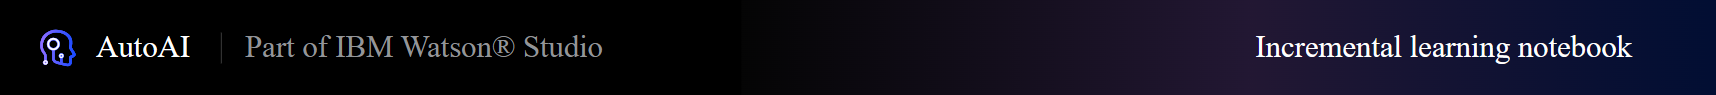
# Pipeline 10 Notebook for training continuation - AutoAI Notebook v2.1.7

Consider these tips for working with an auto-generated notebook:
- Notebook code generated using AutoAI will execute successfully. If you modify the notebook, we cannot guarantee it will run successfully.
- This pipeline is optimized for the original data set. The pipeline might fail or produce sub-optimal results if used with different data.  If you want to use a different data set, consider retraining the AutoAI experiment to generate a new pipeline. For more information, see <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>. 
- Before modifying the pipeline or trying to re-fit the pipeline, consider that the code converts dataframes to numpy arrays before fitting the pipeline (a current restriction of the preprocessor pipeline).


<a id="content"></a>
## Notebook content

This notebook contains code to resume and continue training an AutoAI pipeline partially trained in an AutoAI experiment. If there is additional training data, the notebook retrieves the data in batches and incrementally trains the model, then tests the model.

Some familiarity with Python is helpful. This notebook uses python 3.11 and scikit-learn 1.3.

## Notebook goals

This notebook introduces new commands and demonstrates techniques to support incremental learning, including: 

-  Data reader (read data in batches)
-  Incremental learning (`partial_fit`)
-  Pipeline evaluation

## Contents

This notebook contains the following parts:

**[Setup](#Setup)**<br>
&nbsp;&nbsp;[Package installation](#Package-installation)<br>
&nbsp;&nbsp;[AutoAI experiment metadata](#AutoAI-experiment-metadata)<br>
&nbsp;&nbsp;[watsonx.ai connection](#watsonx.ai-connection)<br>
**[Incremental learning](#Incremental-learning)** <br>
&nbsp;&nbsp;[Get pipeline](#Get-pipeline)<br>
&nbsp;&nbsp;[Read training data (DataLoader)](#Data-loader)<br>
&nbsp;&nbsp;[Incrementally train pipeline model](#Continue-model-training)<br>
&nbsp;&nbsp;[Test pipeline model](#Test-pipeline-model)<br>
**[Store the model](#Store-the-model)**<br>
**[Create online deployment](#Create-online-deployment)**<br>
&nbsp;&nbsp;[Working with spaces](#Working-with-spaces)<br>
**[Summary and next steps](#Summary-and-next-steps)**<br>
**[Copyrights](#Copyrights)**

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm-watsonx-ai,
 - autoai-libs,
 - scikit-learn,
 - snapml


In [1]:
!pip install ibm-watsonx-ai | tail -n 1
!pip install autoai-libs~=2.0 | tail -n 1
!pip install scikit-learn==1.3.* | tail -n 1
!pip install -U lale~=0.8.3 | tail -n 1
!pip install snapml==1.14.* | tail -n 1

<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [2]:
from ibm_watsonx_ai.helpers import DataConnection
from ibm_watsonx_ai.helpers import ContainerLocation

training_data_references = [
    DataConnection(
        data_asset_id='52402e68-604d-4730-b65b-812d176eee3f'
    ),
]
training_result_reference = DataConnection(
    location=ContainerLocation(
        path='auto_ml/f6e1eb9c-64c2-4894-820a-5c84561ce513/wml_data/76d8e9e8-fb8c-47cc-b369-5c5999ab1e77/data/automl',
        model_location='auto_ml/f6e1eb9c-64c2-4894-820a-5c84561ce513/wml_data/76d8e9e8-fb8c-47cc-b369-5c5999ab1e77/data/automl/model.zip',
        training_status='auto_ml/f6e1eb9c-64c2-4894-820a-5c84561ce513/wml_data/76d8e9e8-fb8c-47cc-b369-5c5999ab1e77/training-status.json'
    )
)

The following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [3]:
experiment_metadata = dict(
    prediction_type='multiclass',
    prediction_column='PMGSY_SCHEME',
    holdout_size=0.1,
    scoring='accuracy',
    csv_separator=',',
    random_state=33,
    max_number_of_estimators=2,
    training_data_references=training_data_references,
    training_result_reference=training_result_reference,
    deployment_url='https://eu-gb.ml.cloud.ibm.com',
    project_id='c6c52c52-ce9d-46d6-9859-ab8eb24b1d13',
    drop_duplicates=True,
    include_batched_ensemble_estimators=['BatchedTreeEnsembleClassifier(ExtraTreesClassifier)', 'BatchedTreeEnsembleClassifier(LGBMClassifier)', 'BatchedTreeEnsembleClassifier(RandomForestClassifier)', 'BatchedTreeEnsembleClassifier(SnapBoostingMachineClassifier)', 'BatchedTreeEnsembleClassifier(SnapRandomForestClassifier)', 'BatchedTreeEnsembleClassifier(XGBClassifier)'],
    classes=['PM-JANMAN', 'PMGSY-I', 'PMGSY-II', 'PMGSY-III', 'RCPLWEA'],
    feature_selector_mode='auto'
)

## Set `n_jobs` parameter to the number of available CPUs

In [4]:
import os, ast
CPU_NUMBER = 4
if 'RUNTIME_HARDWARE_SPEC' in os.environ:
    CPU_NUMBER = int(ast.literal_eval(os.environ['RUNTIME_HARDWARE_SPEC'])['num_cpu'])

<a id="connection"></a>
## watsonx.ai connection

This cell defines the credentials required to work with the watsonx.ai Runtime.

**Action**: Provide the IBM Cloud apikey, For details, see [documentation](https://cloud.ibm.com/docs/account?topic=account-userapikey).

In [5]:
import getpass

api_key = getpass.getpass("Please enter your api key (press enter): ")

Please enter your api key (press enter):  ········


In [6]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url=experiment_metadata['deployment_url']
)

In [7]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

if 'space_id' in experiment_metadata:
    client.set.default_space(experiment_metadata['space_id'])
else:
    client.set.default_project(experiment_metadata['project_id'])

training_data_references[0].set_client(client)

<a id="incremental_learning"></a>
# Incremental learning

<a id="preview_model_to_python_code"></a>
## Get pipeline

Download and save a pipeline model object from the AutoAI training job (`lale` pipeline type is used for inspection and `partial_fit` capabilities).

In [8]:
from ibm_watsonx_ai.experiment import AutoAI

pipeline_optimizer = AutoAI(credentials, project_id=experiment_metadata['project_id']).runs.get_optimizer(metadata=experiment_metadata)
pipeline_model = pipeline_optimizer.get_pipeline(pipeline_name='Pipeline_10', astype='lale')

<a id="data_loader"></a>
## Data loader

Create DataLoader iterator to retrieve training dataset in batches. DataLoader is `Torch` compatible (`torch.utils.data`), returning Pandas DataFrames.

**Note**: If reading data results in an error, provide data as iterable reader (e.g. `read_csv()` method from Pandas with chunks). It may be necessary to use methods for initial data pre-processing like: e.g. `DataFrame.dropna()`, `DataFrame.drop_duplicates()`, `DataFrame.sample()`.

```
reader_full_data = pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE)
```

Batch size in rows.

In [9]:
number_of_batch_rows = 2189

In [10]:
from ibm_watsonx_ai.data_loaders import experiment as data_loaders
from ibm_watsonx_ai.data_loaders.datasets import experiment as datasets

dataset = datasets.ExperimentIterableDataset(
    connection=training_data_references[0],
    enable_sampling=False,
    experiment_metadata=experiment_metadata,
    number_of_batch_rows=number_of_batch_rows
    )
    
data_loader = data_loaders.ExperimentDataLoader(dataset=dataset)

<a id="train"></a>
## Continue model training

In this cell, the pipeline is incrementally fitted using data batches (via `partial_fit` calls).

**Note**: If you need, you can evaluate the pipeline using custom holdout data. Provide the `X_test`, `y_test` and call `scorer` on them.


### Define scorer from the optimization metric
This cell constructs the cell scorer based on the experiment metadata.

In [11]:
from sklearn.metrics import get_scorer

scorer = get_scorer(experiment_metadata['scoring'])

### Tuning the incremental learner

For the best training performance set:

- `n_jobs` - to available number of CPUs.

In [12]:
pipeline_model.steps[-1][1].impl.base_ensemble.set_params(n_jobs=CPU_NUMBER)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=4, nthread=None, ...)

### Set up a learning curve plot

In [13]:
import matplotlib.pyplot as plt
from ibm_watsonx_ai.utils.autoai.incremental import plot_learning_curve
import time

partial_fit_scores = []
fit_times = []

<a id="test_model"></a>
### Fit pipeline model in batches

**Tip**: If the data passed to `partial_fit` is highly imbalanced (>1:10), please consider applying the `sample_weight` parameter:

```
from sklearn.utils.class_weight import compute_sample_weight

pipeline_model.partial_fit(X_train, y_train, freeze_trained_prefix=True,
                                             sample_weight=compute_sample_weight('balanced', y_train))
```                                                                                      

**Note**: If you have a holdout/test set please provide it for better pipeline evaluation and replace X_test and y_test in the following cell.

```
from pandas import read_csv
test_df = read_csv('DATA_PATH')

X_test = test_df.drop([experiment_metadata['prediction_column']], axis=1).values
y_test = test_df[experiment_metadata['prediction_column']].values
```

If holdout set was not provided, 30% of first training batch would be used as holdout.



Filter warnings for incremental training.

In [14]:
import warnings

warnings.filterwarnings('ignore')

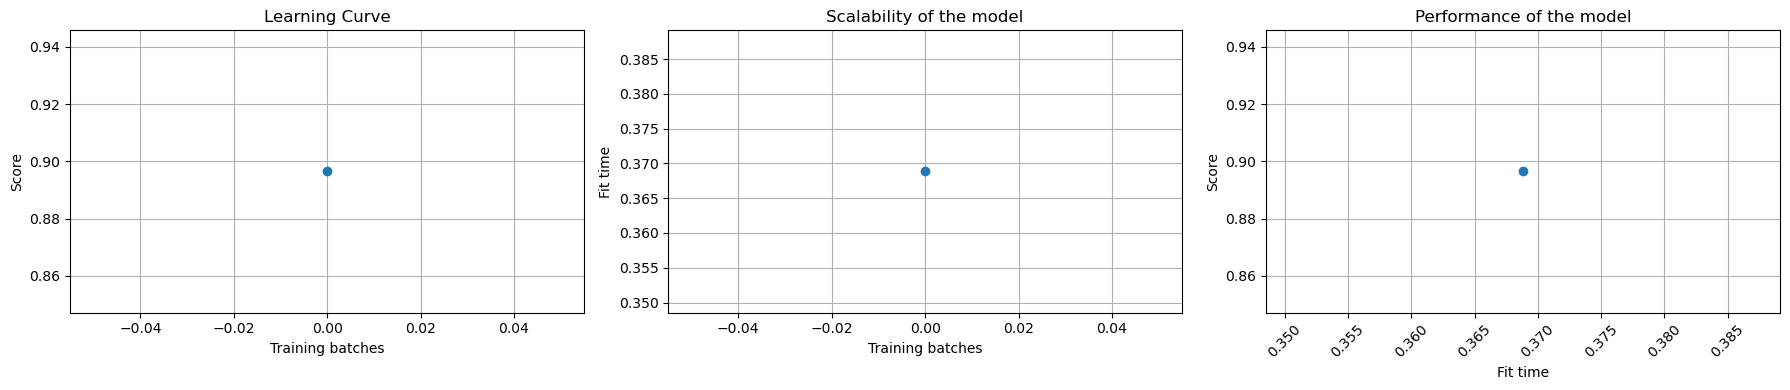

In [15]:
from sklearn.model_selection import train_test_split

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, batch_df in enumerate(data_loader):
    batch_df.dropna(subset=experiment_metadata["prediction_column"], inplace=True)
    X_train = batch_df.drop([experiment_metadata['prediction_column']], axis=1).values
    y_train = batch_df[experiment_metadata['prediction_column']].values
    if i==0:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)
    start_time = time.time()
    pipeline_model = pipeline_model.partial_fit(X_train, y_train, freeze_trained_prefix=True)
    fit_times.append(time.time() - start_time)
    partial_fit_scores.append(scorer(pipeline_model, X_test, y_test))
    plot_learning_curve(fig=fig, axes=axes, scores=partial_fit_scores, fit_times=fit_times)

<a id="test_model"></a>
## Test pipeline model

Test the fitted pipeline (`predict`).

In [16]:
pipeline_model.predict(X_test[:10])

array(['PMGSY-III', 'PMGSY-II', 'PMGSY-III', 'PMGSY-II', 'PMGSY-III',
       'PMGSY-I', 'PMGSY-III', 'PMGSY-I', 'PMGSY-I', 'PMGSY-II'],
      dtype='<U21')

<a id="saving"></a>
## Store the model

In this section you will learn how to store the incrementally trained model.

In [ ]:
model_metadata = {
    client.repository.ModelMetaNames.NAME: 'P10 - Pretrained AutoAI pipeline'
}

stored_model_details = client.repository.store_model(model=pipeline_model, meta_props=model_metadata, experiment_metadata=experiment_metadata)

Inspect the stored model details.

In [ ]:
stored_model_details

<a id="deployment"></a>
## Create online deployment

You can use the commands below to promote the model to space and create online deployment (web service).

<a id="working_spaces"></a>
### Working with spaces

In this section you will specify a deployment space for organizing the assets for deploying and scoring the model. If you do not have an existing space, you can use <a href="https://eu-gb.dataplatform.cloud.ibm.com/ml-runtime/dashboard?context=wx">Deployment Spaces Dashboard</a> to create a new space, following these steps:

- Click **New Deployment Space**.
- Create an empty space.
- Select Cloud Object Storage.
- Select watsonx.ai Runtime and press **Create**.
- Copy `space_id` and paste it below.

**Tip**: You can also use the API to prepare the space for your work. Learn more [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Info**: Below cells are `raw` type - in order to run them, change their type to `code` and run them (no need to restart the notebook). You may need to add some additional info (see the **action** below).

**Action**: Assign or update space ID below.


#### Prepare online deployment

#### Test online deployment

<a id="cleanup"></a>
### Deleting deployment
You can delete the existing deployment by calling the `client.deployments.delete(deployment_id)` command.
To list the existing web services, use `client.deployments.list()`.

<a id="summary_and_next_steps"></a>
# Summary and next steps
You've successfully completed this notebook!
You've learned how to use AutoAI pipeline definition to train the model.
Check out the official [AutoAI site](https://www.ibm.com/cloud/watson-studio/autoai) for more samples, tutorials, documentation, how-tos, and blog posts.

<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2025 IBM. This notebook and its source code are released under the terms of the ILAN License. Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs (or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms), such agreements located in the link below. Specifically, the Source Components and Sample Materials clause included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="https://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF">License Terms</a>

___